## 2a Pràctica IA: Machine Learning


En aquesta pràctica el nostre objectiu és aplicar diferents classificadors a un problema real. En el nostre cas, prediurem les probabilitats de sobreviure al Titanic segons unes característiques elegides.

### 1 Exploratory Data Analysis


#### 1.1 Imports Necessaris

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#### 1.1 Carregar dataset

Primer de tot, ens encarrem de carregar el dataset amb la llibreria pandas.

In [4]:
data=pd.read_csv("./dades.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 1.2 Observació de dades

Durant aquesta fase de la EDA, hem de obtenir la màxima informació del dataset possible, mitjançant gràfics i altres mesures. Anem a veure les primeres instàncies del dataset:

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


De moment, podem observar que les característiques del nostre dataset són categòriques o numèriques. EXPLICAR ALGO JOAN PLS AJUDA

In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Després d'haver vist la descripció amb les primeres files del dataset podem observar qiue ens trobam davant un dataset amb 891 mostres amb 11 característiques, descartant la de survived. Si el nostre objectiu és prediure la supervivència, anem a veure quina informació podem concloure del nostre dataset.

#### 1.2.1 Edat

Primer de tot, veurem la quantitat de gent que hi ha i la mitja d'edat.

In [108]:
y

[     PassengerId  Survived  Pclass  \
 141          142         1       3   
 151          152         1       1   
 289          290         1       3   
 323          324         1       2   
 356          357         1       1   
 376          377         1       3   
 539          540         1       1   
 553          554         1       3   
 554          555         1       3   
 608          609         1       2   
 708          709         1       1   
 
                                                   Name     Sex   Age  SibSp  \
 141                           Nysten, Miss. Anna Sofia  female  22.0      0   
 151                  Pears, Mrs. Thomas (Edith Wearne)  female  22.0      1   
 289                               Connolly, Miss. Kate  female  22.0      0   
 323  Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...  female  22.0      1   
 356                        Bowerman, Miss. Elsie Edith  female  22.0      0   
 376                    Landergren, Miss. Aurora A

Gent de3 ha sobreviscut:  2
hola 3
2.0


Text(0, 0.5, 'Quantitat')

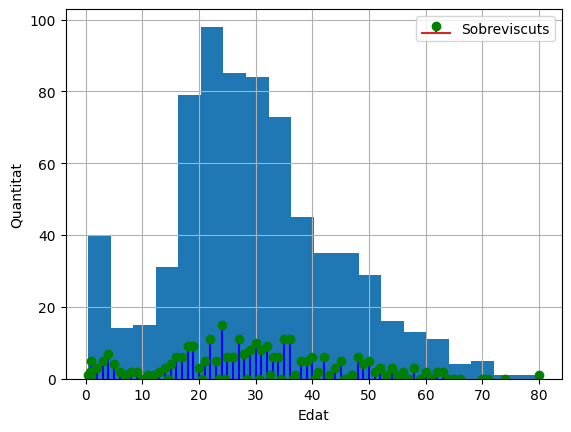

In [138]:
data.Age.hist(bins=20)
y=[len(data.loc[(data['Age']==x)&(data['Survived']==1)]) for x in data.Age.unique()]
edat=y[6]
print(f"Gent de{edat} ha sobreviscut:  "+str(len(data.loc[(data['Age']==6)&(data['Survived']==1)])))
print("hola "+str(y[6]))
print(str(data.Age.unique()[6]))
#plt.legend("edat",loc="upper right")
plt.stem(data.Age.unique(),y, 'b',label='Sobreviscuts', markerfmt='go')
plt.legend()
plt.xlabel("Edat")
plt.ylabel("Quantitat")

In [78]:
# peaks for survived/deceased passengers by their age
facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill= True)
#facet.map(sns.histplot(data=data['Age'],
 #          color='crimson', label='train', fill=True))
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()


plt.figure
plt.hist(x=[1,2,3,4,5],y=[1,2,3,5,5])


(array([1., 0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000028AA11B8B80> (for post_execute):


C:\Users\Jaume\miniconda3\envs\ia2022\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: setting an array element with a sequence.

ValueError: setting an array element with a sequence.

<Figure size 1272.11x300 with 1 Axes>

A l'anterior grafic, podem obervar la quantitat de persones que tenen una edat determinada. Podem veure que la franja d'edat més freqüentada és la de entre 20 i 30 anys.

In [ ]:
data.Sex.value_counts().plot(kind='barh')
plt.legend(loc="upper right")

In [ ]:
data.Pclass.value_counts().plot(kind='barh')
plt.legend(loc="upper right")

Com es pot observar, l'anterior gràfic mostra la quantitat de persones que pertanyen a cada una de les 3 classes de passatgers. A més, també podem observar la quantitat de morts que hi va haver de cada una d'aquestes classes 

In [ ]:
d1 = data[(data.Survived == 1) & (data.Pclass == 1)]
d2 = data[(data.Survived == 1) & (data.Pclass == 2)]
d3 = data[(data.Survived == 1) & (data.Pclass == 3)]

sobreviuen1 = d1.Pclass.value_counts()
sobreviuen2 = d2.Pclass.value_counts()
sobreviuen3 = d3.Pclass.value_counts()

classes = data.Pclass.value_counts()
classes['s1'] = sobreviuen1 #Extreure quantitat de persones de primera classe que tenen Survived = 1
classes['s2'] = sobreviuen2 #Extreure quantitat de persones de segona classe que tenen Survived = 1
classes['s3'] = sobreviuen3 #Extreure quantitat de persones de tercera classe que tenen Survived = 1
classes


In [ ]:
mitjaSupervivenciaSexe=pd.concat([data['Sex'], data['Survived']], axis=1).groupby('Sex').Survived.mean()
mitjaSupervivenciaSexe.plot(kind='barh')
plt.legend(loc="upper right")

Després d'haver explorat tot el nostre dataset del Titanic, obtenim aquestes conclusions:
#### 1.La majoria de la gent té entre 20-30 anys.
#### 2.La majoria són homes
#### 3.La majoria estava a tercera classe,suposam que era la més econòmica.
#### 4.El % de supervivència en dones és molt major que els homes, suposant que tenien lloc abans en els bots auxiliars.


### 1.2 Manipulació dades


Després d'haver observat el dataset podem eliminar diverses característiques que no ens serviran. Per exemple: PassengerId només ens serveix per a enumerar les files. A continuació eliminarem les columnes que no ens aporten gran informació respecte al percentage de supervivència.

In [ ]:
data.drop(["PassengerId","Ticket","Name"],inplace=True,axis=1)
print("La quantitat de NAN's en Cabin es {}/{}".format(data['Cabin'].isna().sum(),len(data)))

Després d'haver eliminat aquestes columnes podem observarque la columna Cabin té gran quantitat de NAN's.També podem observar que tant PassengerID com ticket i Name ens serveixen de identificadors, informació que no sirà molt relevant. Ara eliminam Cabin.

In [ ]:
data=data.drop(["Cabin"],axis=1)

In [ ]:
data.head()

Ara, després d'haver eliminat les característiques que trobam innecessàries o millor dit, no tant relevants, observarem si ens falta informació a les columnes que agafarem finalment.

In [ ]:
total = data.isnull().sum().sort_values(ascending = False)
percentatge = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
ms=pd.concat([total, percentatge], axis=1, keys=['Total', 'percentatge'])
ms= ms[ms["percentatge"] > 0]
ms

Com podem observar, ens falten 177 valors per a l'edat i 2 per a Embarked. Ens centrarem principalment en l'edat ja que és una característica molt més important i que té més relació amb la supervivència. La opció més viable és substituir tots aquests valors per la mitjana. A més, eliminarem les dues files amb el valor NaN de Embarked.


In [ ]:
data['Age'].fillna(value=data['Age'].median(),inplace=True)

In [ ]:
data.dropna(subset=['Embarked'],inplace=True)

### 1.2.3 Dades Categòriques

En aquesta fase de la neteja de dades obtindrem les dades categòriques i les transformarem a numèriques per a poder entrenar amb elles el nostre model. 

In [ ]:
data.head()

Tenim dues columnes categòriques, el sexe i Embarked. Utilitzarem una substitució per 1 en el cas de home i 2 en el cas de dona ja que tan sols hi ha dos possibles valors. En el cas de Embarked, utilitzarem el one hot encoding(hi ha 3 possibles valors).

In [ ]:
data['Sex']=data['Sex'].map({'male':1,'female':0}) #Canviam els valors de sexe
embark=data.pop('Embarked')
ohe_embark=pd.get_dummies(embark,prefix='embk')
data=pd.concat([data.reset_index(drop=True),ohe_embark.reset_index(drop=True)],axis=1,sort=False)


In [ ]:
pclass=data.pop('Pclass')
ohe_class=pd.get_dummies(pclass,prefix='class')
data=pd.concat([data.reset_index(drop=True),ohe_class.reset_index(drop=True)],axis=1,sort=False)


In [ ]:
data

Com a darrera passa per a tenir les dades netes, hauríem de normalitzar les columnes amb valors numèrics alts com Age o Fare. Utilitzarem l'StandardScaler de la llibreria sklearn.

In [ ]:
scaler = StandardScaler()
data.Age=scaler.fit_transform(data.Age.values.reshape(-1,1))
data.Fare=scaler.fit_transform(data.Fare.values.reshape(-1,1))
data.SibSp=scaler.fit_transform(data.SibSp.values.reshape(-1,1))
data.Parch=scaler.fit_transform(data.Parch.values.reshape(-1,1))
data

In [ ]:
data['Parch'].max()

Després d'haver fet la neteja de dades i obtingut la matriu de correlació ens adonem compte que els principals factors que intervenen en la predicció i que tenen més importància són aquests:

1.Pclass: amb un valor de -0.33, significa que quant menor és la classe, més probabilitats de sobreviure hi ha.
2.Sex: amb un valor de 0.54, significa que quan major sigui aquest valor major prob. de supervivència tindrà la persona. Això es dona ja que hem substituit home per 0 i dona per 1. Si fos al revés, és a dir, que dona fos un nombre inferior que home, aquesta correlació siria negeativa, al tenir més probabilitats de sobreviure quan menor sigui el nombre enter.
3.Fare: té un valor de 0.25, indica la quantitat de diners que es varen pagar. Aquesta columna va lligada amb Pclass ja que quant més es pagava, millor classe es tenia i per tant, major % de sobreviure.

## 1.3 Entrenament

In [ ]:
label=data['Survived']

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35, random_state=42)
X_train.pop('Survived')
X_test.pop('Survived')                                                   

In [ ]:
logistic_reg=linear_model.LogisticRegression()
hist=logistic_reg.fit(X_train,y_train)

In [ ]:
hist

In [ ]:
parameters={'tol':[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], 'C':[np.arange(0.1,2.0,0.1,dtype=float)]}
grid=GridSearchCV(estimator=logistic_reg,param_grid=parameters,cv = 2, n_jobs=-1)

In [ ]:
grid.fit(data, data.Survived)

## 1.4 Avaluació


In [ ]:
prediccio=logistic_reg.predict(X_test)
print('The accuracy of the Logistic Regression is',round(accuracy_score(prediccio,y_test)*100,2))

## 1.5 Funció avaluació segons test size


In [ ]:
x=np.arange(0.05, 0.80, 0.01, dtype=float)
y=[]
for i in x:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=i, random_state=42)
    X_train.pop('Survived')
    X_test.pop('Survived')
    logistic_reg=linear_model.LogisticRegression()
    hist=logistic_reg.fit(X_train,y_train)
    prediccio=logistic_reg.predict(X_test)
    y.append(round(accuracy_score(prediccio,y_test)*100,2))

In [ ]:
y
plt.plot(x,y)
plt.show
plt.legend("percentatge de precisió segons la distribució train-test",loc="upper right")

In [ ]:
percep=linear_model.Perceptron()
percep.fit(X_train,y_train)
importance=percep.coef_
print(importance)
# plot feature importance

In [ ]:
predict=percep.predict(X_test)


In [ ]:
x=np.arange(0.05, 0.80, 0.01, dtype=float)
y=[]
for i in x:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=i, random_state=42)
    X_train.pop('Survived')
    X_test.pop('Survived')
    percep=linear_model.Perceptron(tol=1e-3,random_state=0)
    percep.fit(X_train,y_train)
    prediccio=logistic_reg.predict(X_test)
    y.append(round(accuracy_score(prediccio,y_test)*100,2))

In [ ]:
y
plt.plot(x,y)
plt.show
plt.legend("hola",loc="upper right")

In [ ]:
print("Accuracy: "+str(accuracy_score(predict,y_test)))

In [ ]:
from sklearn import tree

In [ ]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(X_train, y_train)
predict=decision_tree.predict(X_test)
print("Accuracy: "+str(accuracy_score(predict,y_test)))